In [68]:
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import contextily as ctx

## Load Data

Processed in population_data.ipynb notebook.

In [69]:
tyne_oa = gpd.read_file("data/tyne_oa")
tyne_oa.head()

,oa11cd,lad11cd,X,Y,Population,geometry
0,E00042042,E08000021,421259.393,564639.754,310,"POLYGON ((421301.772 564928.429, 421301.755 56..."
1,E00042043,E08000021,420448.616,564819.213,304,"POLYGON ((420572.364 564892.821, 420572.312 56..."
2,E00042044,E08000021,420509.207,564622.209,246,"POLYGON ((420492.559 564780.806, 420492.590 56..."
3,E00042045,E08000021,421551.722,564088.460,201,"POLYGON ((421543.715 563955.116, 421542.251 56..."
4,E00042046,E08000021,422116.597,563648.529,424,"POLYGON ((422292.813 563736.716, 422265.374 56..."


## Calculate Distances Between Output Areas

In [70]:
centroids = np.array([tyne_oa["X"], tyne_oa["Y"]]).T
centroids.shape

(952, 2)

In [73]:
dist_sq = np.sum((centroids[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2,
                 axis = -1)

distances = np.sqrt(dist_sq)

Max distance of 16923.71770783074 m is between E00042743 and E00139704


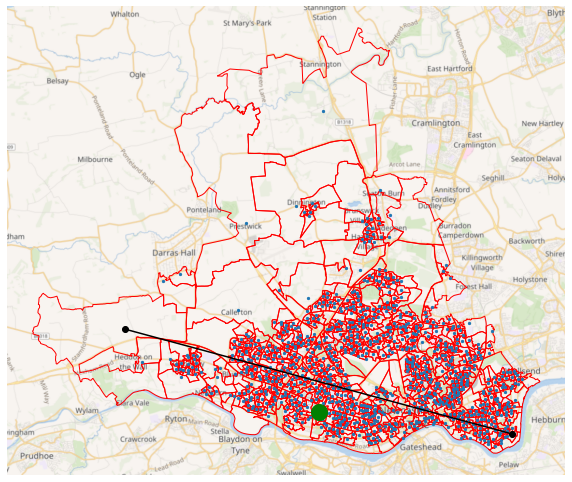

In [112]:
max_idx = np.where(distances == distances.max())[0]
print("Max distance of",
      distances.max(),
      "m is between",
      tyne_oa.iloc[max_idx[0]]["oa11cd"],
      "and", tyne_oa.iloc[max_idx[1]]["oa11cd"])

ax = tyne_oa.plot(figsize=(10,10), facecolor='none', edgecolor='red')
ctx.add_basemap(ax,
                url="https://maps.wikimedia.org/osm-intl/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

x = tyne_oa["X"]
y = tyne_oa["Y"]
ax.scatter(x, y, s=5)

x = tyne_oa.iloc[max_idx]["X"]
y = tyne_oa.iloc[max_idx]["Y"]
ax.plot(x, y, 'k-o')

ax.set_axis_off()

## Calculate "satisfaction"

Satisfaction at any output area due to a sensor placed in any other output area.

In [177]:
# normalised distances
distances_norm = distances / distances.std()

print(distances_norm.min())
print(distances_norm.mean())
print(distances_norm.max())
print(distances_norm.std())

0.0
1.8186540653687548
6.282840655920707
0.9999999999999997


In [178]:
def distance_to_satisfaction(distance, theta=1):
    return np.exp(- distance / theta)

distance_to_satisfaction = np.vectorize(satisfaction)

In [179]:
satisfaction = distance_to_satisfaction(distances, theta=500)

Text(0.5, 1, 'Satisfaction due to sensor at E00042042')

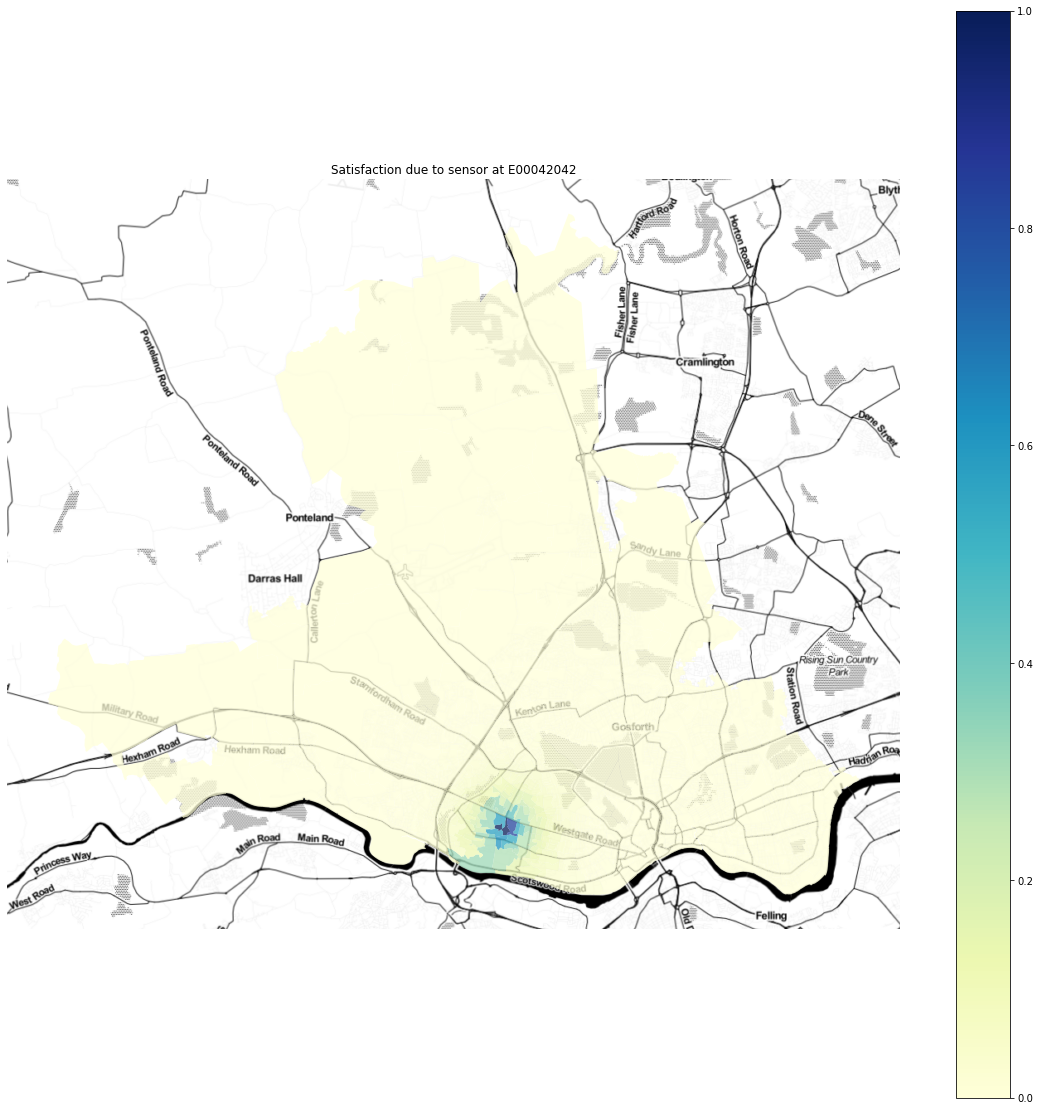

In [180]:
# satisfaction due to sensor at this output area index
sensor_idx = 0

tyne_oa["satisfaction"] = satisfaction[sensor_idx]

ax = tyne_oa.plot(column="satisfaction",
                  figsize=(20,20),alpha=0.75,
                  cmap="YlGnBu", legend=True)

ctx.add_basemap(ax,
                url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

ax.set_axis_off()
plt.title("Satisfaction due to sensor at " +
          tyne_oa.iloc[sensor_idx]["oa11cd"])

In [212]:
sensors = np.zeros((len(tyne_oa)))

# add sensors at random location
n_sensors = 10
sensor_idx = np.random.randint(0, len(tyne_oa), size=n_sensors)
sensors[sensor_idx] = 1

# only keep satisfactions due to output areas where a sensor is present
mask_sat = np.multiply(satisfaction, sensors[np.newaxis, :])

# satisfaction at each output area = satisfaction due to nearest sensor
max_mask_sat = np.max(mask_sat, axis=1)

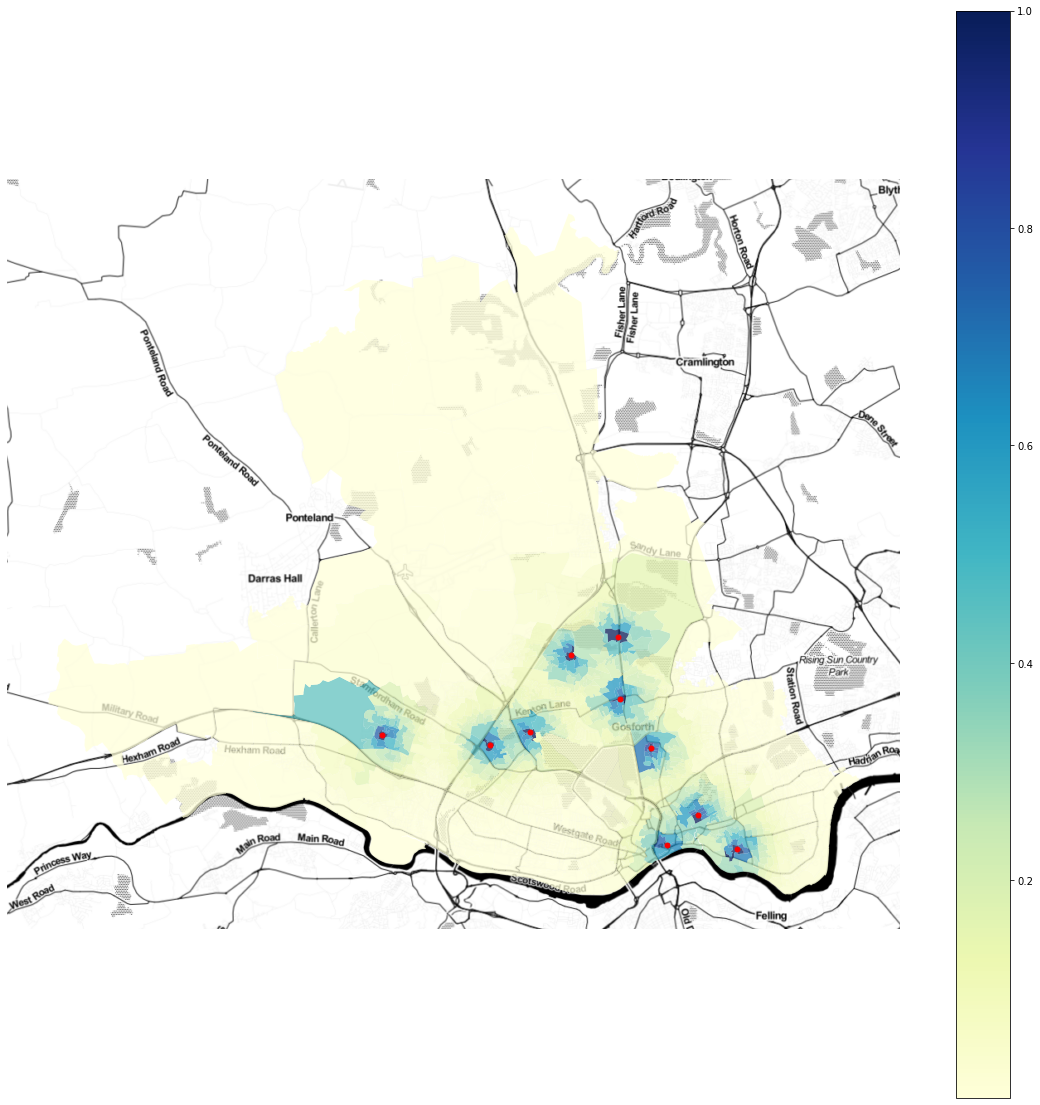

In [217]:
tyne_oa["satisfaction"] = max_mask_sat

ax = tyne_oa.plot(column="satisfaction",
                  figsize=(20,20),alpha=0.75,
                  cmap="YlGnBu", legend=True)

ctx.add_basemap(ax,
                url="http://a.tile.stamen.com/toner/{z}/{x}/{y}.png",
                crs=tyne_oa.crs)

ax.set_axis_off()

x = tyne_oa.iloc[sensor_idx]["X"]
y = tyne_oa.iloc[sensor_idx]["Y"]
ax.scatter(x, y, s=24, color='r')


In [211]:
sensor_idx = np.random.randint(0, len(tyne_oa), size=n_sensors)
sensor_idx

array([ 50, 594, 117, 191, 435, 391, 886, 532,  90, 468])